In [1]:
import glob
import os

!pip install matplotlib
import matplotlib.pyplot as plt
!pip install numpy
import numpy as np
!pip install librosa
import librosa
import librosa.display
!pip install pretty_midi
import pretty_midi
!pip install pypianoroll
import pypianoroll

# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

# change path if necessary
# os.chdir("/content/drive/My Drive/research/MIDIconversion_marovany")
print('Working dir : ', os.getcwd())

Working dir :  C:\Users\admin\Project\MIDIconversion_marovany


In [5]:
def estimate_note_pitch(y, onset_frames):
  """
  Params :
  
  Return :
  f0 : Fundamental frequency (np.ndarray)
  times : array of time values
  single_f0_estimation : median of f0 list
  """
  f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C1'),
                                              fmax=librosa.note_to_hz('C7'))
  times = librosa.times_like(f0)
  list_f0 = []
  for ll in onset_frames:
    list_f0.append(list(f0[ ll - 5 : ll+5]))
  single_f0_estimation = np.nanmedian(np.concatenate(list_f0, axis=0))
  return single_f0_estimation, f0, times


def onset_detection(y, sr, delta=0.5):
  """
  Params :
  
  Return :
  o_env : onset strenght envelop
  times : ndarray of time values (in seconds) to match the time axis from a feature matrix
  onset_frames : ndarray of note onset events
  """
  o_env = librosa.onset.onset_strength(y=y, sr=sr)
  times = librosa.times_like(o_env, sr=sr)
  onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr, 
                                            delta=delta, normalize=True)
  return onset_frames, times, o_env


def plot_onsets_and_pitch_detection(figsize, times, f0, o_env, onset_frames):
  plt.rcParams['figure.figsize'] = figsize
  fig, ax = plt.subplots(nrows=2, sharex=True)
  S_db = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
  librosa.display.specshow(S_db, x_coords=times, y_axis='log', ax=ax[0])
  ax[0].plot(times, f0, label='f0', color='cyan', linewidth=3)
  ax[0].legend(loc='upper right')
  
  ax[1].plot(times, o_env, label='Onset strength')
  ax[1].vlines(times[onset_frames], 0, o_env.max(), color='r', 
                alpha=0.9, linestyle='--', label='Onsets')
  ax[1].legend()
  plt.show()


# def add_detected_notes_to_instrument(times, onset_frames, MIDInote, duration):
#   for ll in times[onset_frames]: # onset_frames entry in times ?
#     # Create a Note instance for each detected note
#     note = pretty_midi.Note(velocity=100, pitch=round(MIDInote), 
#                             start=ll, end=ll+duration)
#     # Add it to our instrument
#     banjo_instrument.notes.append(note)


print('processed')

processed



 Now processing file capteurs\17-D5-140707_1606.wav
--> found 4 notes
--> found a pitch of 255.65002913072473 (Hz), i.e. a C4


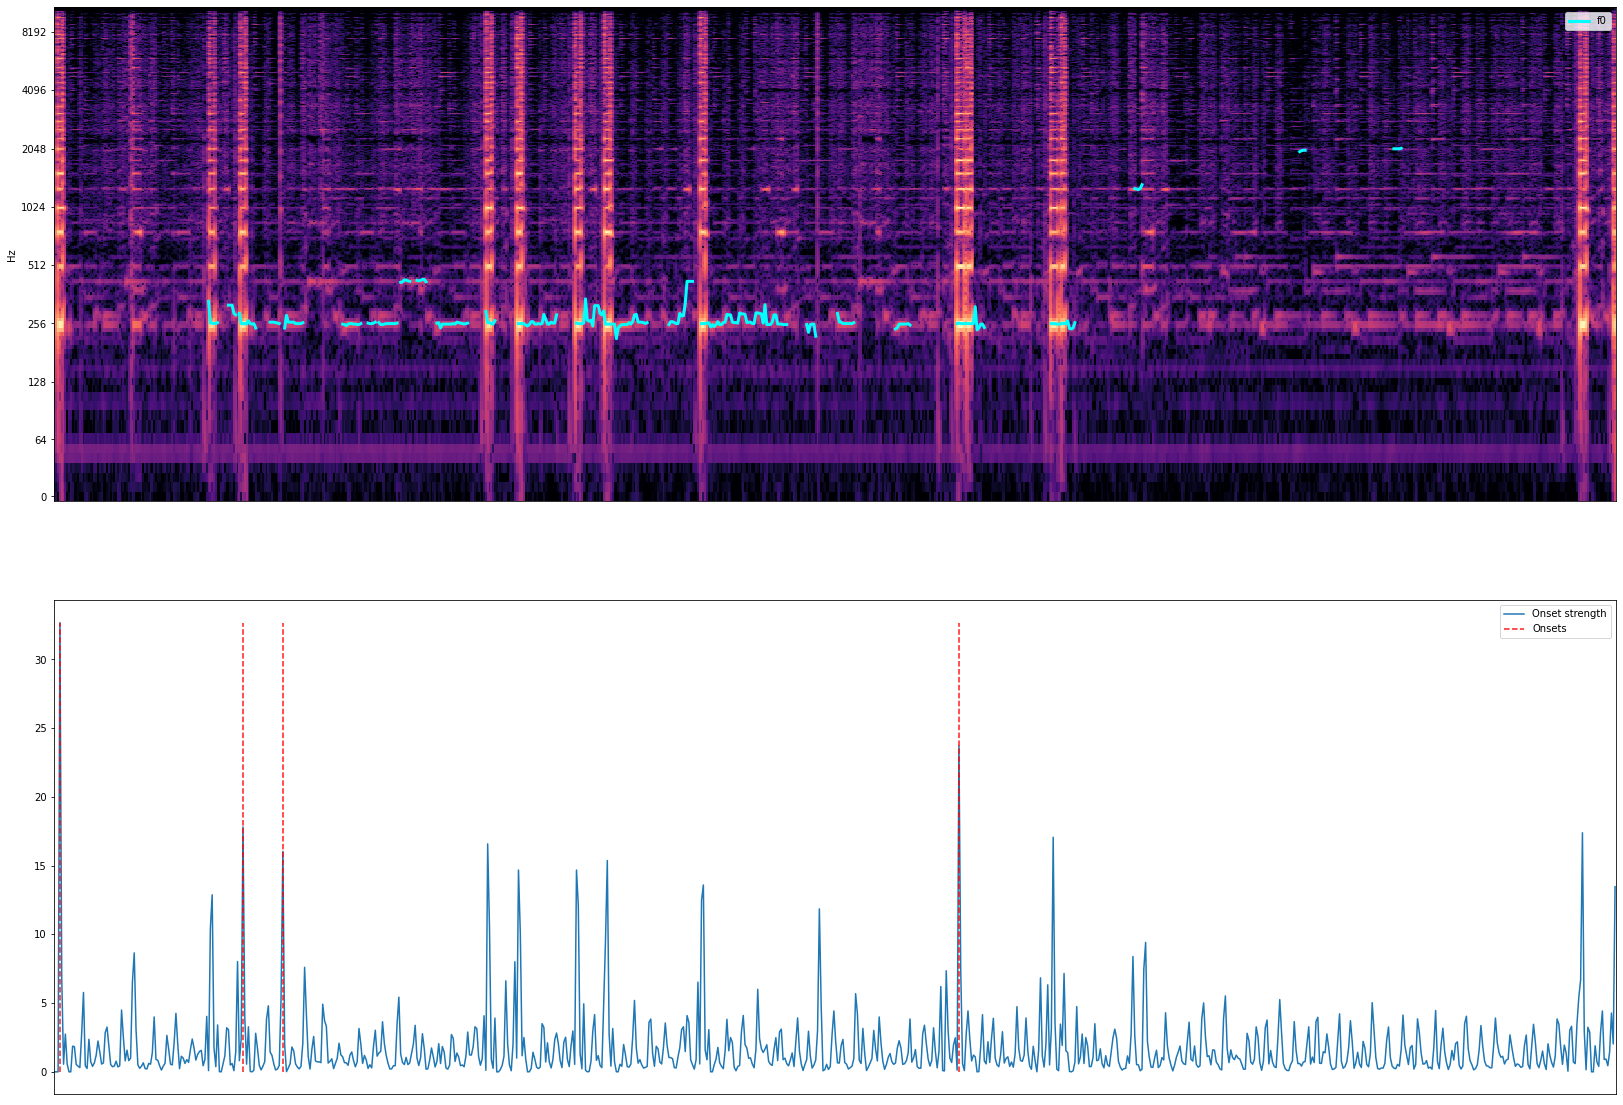


 Now processing file capteurs\20-D8-140707_1606.wav
--> found 12 notes
--> found a pitch of 316.5653876023804 (Hz), i.e. a D#4


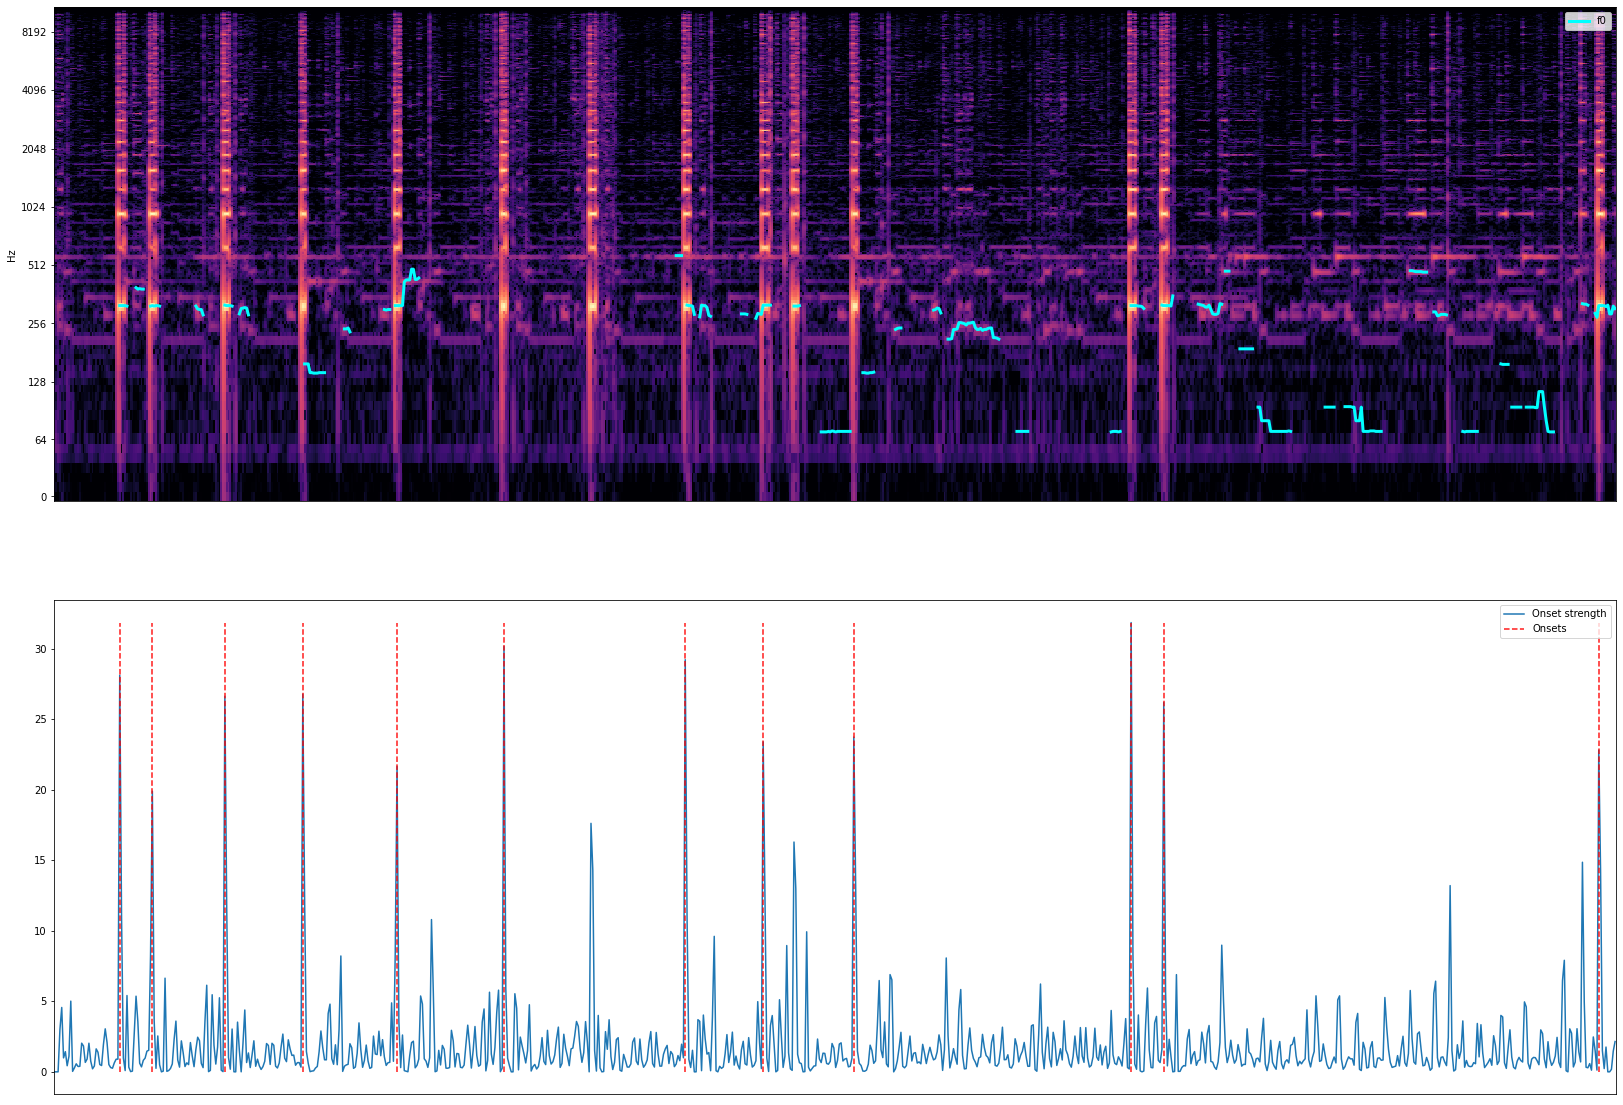

[<AxesSubplot:xlabel='time (beat)', ylabel='\n\npitch'>]

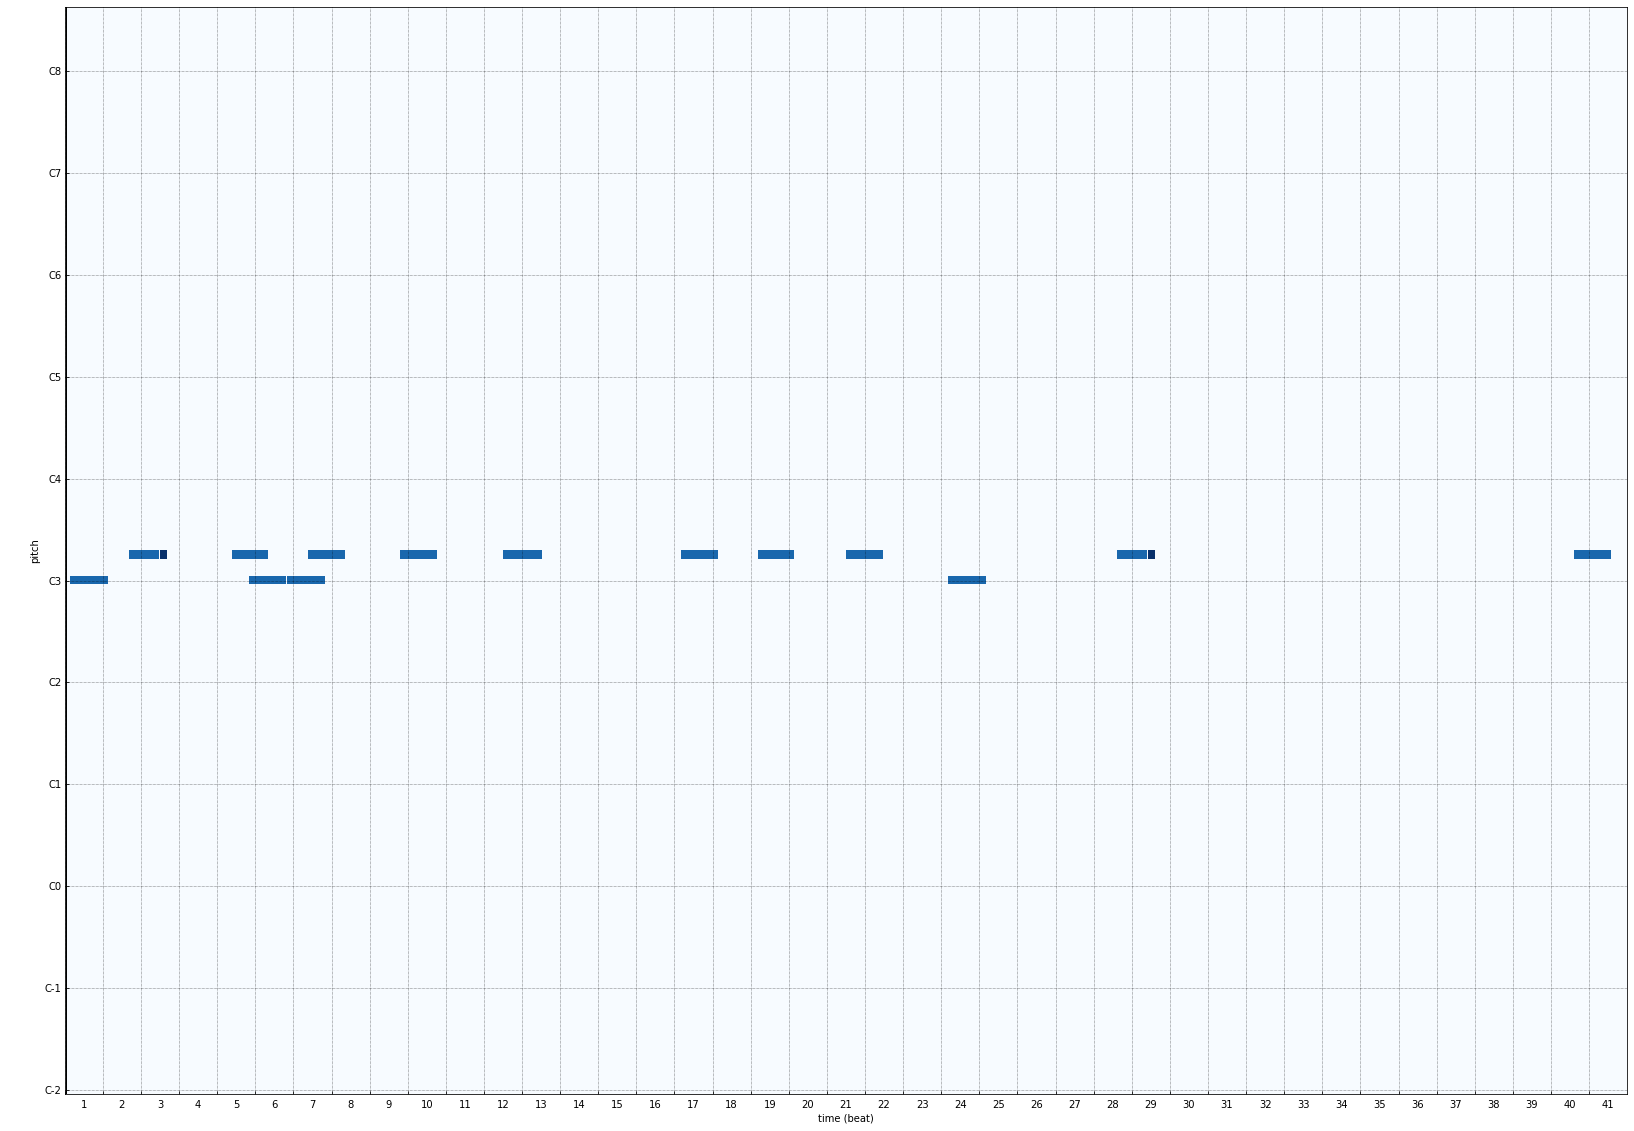

In [6]:
do_plot = True
duration = 0.5
verbose = True
delta = [0.4, 0.4]
list_notes = []
# Create a PrettyMIDI object
prettyMIDI = pretty_midi.PrettyMIDI()
# Create an Instrument instance for a banjo instrument
banjo_program = pretty_midi.instrument_name_to_program('Banjo')
banjo_instrument = pretty_midi.Instrument(program=banjo_program)
ct = 0

for wav_file in glob.glob('capteurs/*wav'):
  if verbose:
    print('\n Now processing file', wav_file)

  # audio data loading
  """
  sr : sampling rate
  y : audio time series (np.ndarray)
  """
  y, sr = librosa.load(wav_file, offset=4, duration=20)

  # onset detection 
  onset_frames, times, o_env = onset_detection(y, sr, delta[ct])

  if verbose:
    print('--> found', len(onset_frames), 'notes')

  if len(list_notes)==0:  # should always be empty
    # pitch estimation
    single_f0_estimation, f0, times = estimate_note_pitch(y, onset_frames)
    MIDInote = pretty_midi.hz_to_note_number(single_f0_estimation)
    if verbose:
      print('--> found a pitch of', single_f0_estimation, 
            '(Hz), i.e. a', pretty_midi.note_number_to_name(MIDInote))    
  else:
    MIDInote = pretty_midi.note_name_to_number(list_notes[ct])

  # def add_detected_notes_to_instrument(times, onset_frames, MIDInote, duration):
  for ll in times[onset_frames]: # onset_frames entry in times ?
    # Create a Note instance for each detected note
    note = pretty_midi.Note(velocity=100, pitch=round(MIDInote), 
                            start=ll, end=ll+duration)
    # Add it to our instrument
    banjo_instrument.notes.append(note)
  # add_detected_notes_to_instrument()

  # plot onsets and pitch detection
  if do_plot:
    plot_onsets_and_pitch_detection(figsize=[28, 20], times=times, f0=f0, 
                                    o_env=o_env, onset_frames=onset_frames)

  ct+=1

# Add the cello instrument to the PrettyMIDI object
prettyMIDI.instruments.append(banjo_instrument)

# Write out the MIDI data
prettyMIDI.write('marovany.mid')

multitrack = pypianoroll.read("marovany.mid")
multitrack.plot()

Sources

- https://github.com/craffel/pretty-midi
- https://librosa.org/doc/latest/index.html

In [ ]:
import sys

sys.exit()